In [1]:
import json

bvh_dataset = "./datasets/mocap/dataset_v2.json"
triang_data_file = "./datasets/yolo/triangulation_select.json"
selected_names_file = "./datasets/mediapipe/selected_joint_names.json"


with open(bvh_dataset, 'r') as file:
    data_3d = json.load(file)

with open(selected_names_file, 'r') as file:
    selected_names = json.load(file)

with open(triang_data_file, 'r') as file:
    triangulation_data = json.load(file)


In [21]:
sample_seq = 'p4s1'
selected_seq = data_3d[sample_seq]

In [22]:
selected_seq[0]

{'lfemur': [8.287893295288086, 3.8033363819122314, 0.1163821816444397],
 'ltibia': [8.421300888061523, 1.9008748531341553, -0.06309393048286438],
 'lfoot': [8.760259628295898, 0.10237276554107666, -0.25035858154296875],
 'rfemur': [8.18842601776123, 3.7926883697509766, -1.07268226146698],
 'rtibia': [8.296483039855957, 1.9781861305236816, -0.8983211517333984],
 'rfoot': [8.633221626281738, 0.10214114189147949, -0.6843364834785461],
 'lhumerus': [8.38395881652832, 6.197987079620361, 0.21688944101333618],
 'lradius': [8.672024726867676, 4.811230659484863, 0.4203581213951111],
 'lwrist': [8.540379524230957, 4.099964141845703, 0.6149471998214722],
 'rhumerus': [8.48794174194336, 6.167164325714111, -1.29099440574646],
 'rradius': [8.553568840026855, 4.7409796714782715, -1.4208775758743286],
 'rwrist': [8.41553020477295, 4.018771648406982, -1.5357036590576172]}

In [23]:
SCALE_FACTOR = 255

lfoot_height_z = [frame['lfoot'][1]*SCALE_FACTOR for frame in selected_seq]
rfoot_height_z = [frame['rfoot'][1]*SCALE_FACTOR for frame in selected_seq]


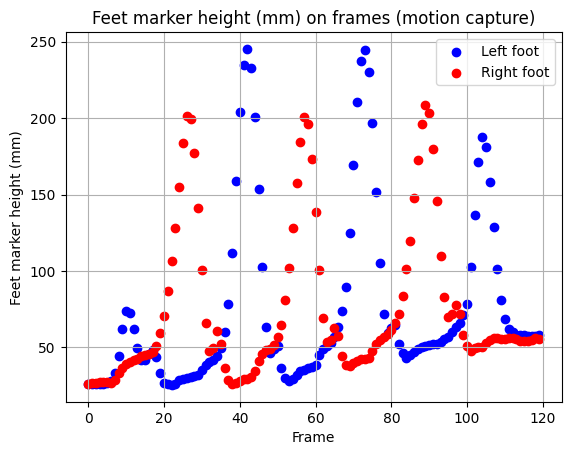

In [24]:
import matplotlib.pyplot as plt

frame_num = [i for i in range(len(lfoot_height_z))]

plt.scatter(frame_num, lfoot_height_z, color='blue', label='Left foot')
plt.scatter(frame_num, rfoot_height_z, color='red', label='Right foot')

plt.title('Feet marker height (mm) on frames (motion capture)')
plt.legend()

plt.xlabel('Frame')
plt.ylabel('Feet marker height (mm)')
plt.grid(True)
plt.show()

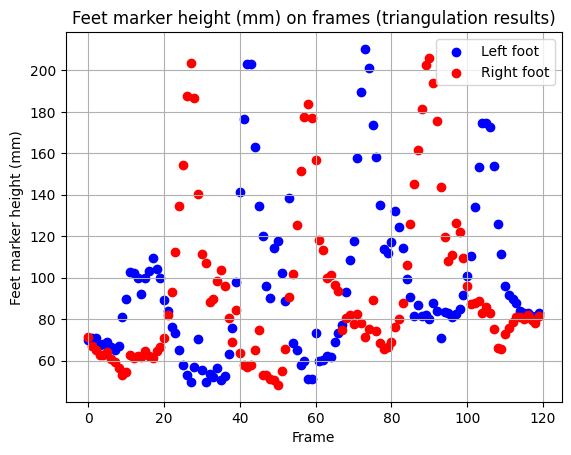

In [25]:
lfoot_height_z_triang = [frame['lfoot'][2] for frame in triangulation_data[sample_seq]]
rfoot_height_z_triang = [frame['rfoot'][2] for frame in triangulation_data[sample_seq]]

frame_num = [i for i in range(len(lfoot_height_z))]

plt.scatter(frame_num, lfoot_height_z_triang, color='blue', label='Left foot')
plt.scatter(frame_num, rfoot_height_z_triang, color='red', label='Right foot')

plt.title('Feet marker height (mm) on frames (triangulation results)')
plt.legend()

plt.xlabel('Frame')
plt.ylabel('Feet marker height (mm)')
plt.grid(True)
plt.show()

In [26]:
def find_local_minima(data, window_size=5):
    local_minima_indices = []
    
    for i in range(window_size, len(data) - window_size):
        window_prev = data[i-window_size:i]
        window_next = data[i+1:i+window_size+1]
        current = data[i]
        
        if current < min(window_prev) and current < min(window_next):
            local_minima_indices.append(i)

    return local_minima_indices


print("Local minima indices lfoot:", find_local_minima(lfoot_height_z, 10))

Local minima indices lfoot: [22, 53, 84]


In [27]:
print("Local minima indices rfoot:", find_local_minima(rfoot_height_z, 10))

Local minima indices rfoot: [38, 69, 101]


In [28]:
print("Local minima indices lfoot (triangulated):", find_local_minima(lfoot_height_z_triang, 10))
print("Local minima indices rfoot (triangulated):", find_local_minima(rfoot_height_z_triang, 10))

Local minima indices lfoot (triangulated): [27, 59, 93]
Local minima indices rfoot (triangulated): [50, 78, 109]


In [15]:
from scripts.parsers import parse_sequences as parse_sequence_info

file_path = 'gait3d\\ListOfSequences.txt'
sequences = parse_sequence_info(file_path)

In [16]:
for sequence, params in sequences.items():
    if params['MoCap_data']:
        lfoot_height_z = [frame['lfoot'][1]*SCALE_FACTOR for frame in data_3d[sequence]]
        rfoot_height_z = [frame['rfoot'][1]*SCALE_FACTOR for frame in data_3d[sequence]]
        left_minima = find_local_minima(lfoot_height_z, 10)
        right_minima = find_local_minima(rfoot_height_z, 10)
        
        sorted_minima = sorted(right_minima + left_minima)
        order = ""

        for minim in sorted_minima:
            if minim in left_minima:
                order += "L"
            else:
                order += "R"

        alternately = True
        for i in range(len(order) - 1):
            if order[i] == order[i+1]:
                alternately = False
                break

        print(f"{sequence} | {'OK' if alternately else 'NO NO NO NO NO' } | {order} | L: {left_minima} | R: {right_minima}")

p1s1 | OK | LRLRLRL | L: [19, 51, 83, 114] | R: [36, 67, 98]
p1s2 | OK | LRLRLR | L: [22, 53, 84] | R: [38, 68, 99]
p1s3 | OK | LRLRLRL | L: [17, 47, 77, 107] | R: [32, 62, 92]
p1s4 | OK | LRLRLR | L: [18, 48, 78] | R: [34, 64, 95]
p2s1 | OK | RLRLRLRL | L: [36, 66, 96, 123] | R: [23, 52, 81, 112]
p2s2 | OK | RLRLRLR | L: [29, 56, 84] | R: [18, 44, 70, 99]
p2s3 | OK | LRLRLRL | L: [19, 48, 76, 106] | R: [34, 63, 91]
p2s4 | OK | LRLRLRLR | L: [10, 35, 61, 88] | R: [23, 50, 74, 103]
p3s1 | OK | LRLRLRLR | L: [16, 48, 78, 104] | R: [35, 64, 94, 127]
p3s2 | OK | RLRLRLR | L: [27, 52, 80] | R: [14, 40, 66, 95]
p3s3 | OK | LRLRLRLR | L: [17, 50, 79, 109] | R: [34, 65, 96, 128]
p3s4 | OK | RLRLRLR | L: [36, 61, 87] | R: [23, 49, 74, 100]
p4s1 | OK | LRLRLR | L: [22, 53, 84] | R: [38, 69, 101]
p4s2 | OK | LRLRLR | L: [20, 51, 81] | R: [37, 67, 97]
p4s3 | OK | RLRLRL | L: [36, 67, 101] | R: [20, 51, 83]
p4s4 | OK | RLRLRL | L: [35, 65, 96] | R: [18, 50, 81]
p5s1 | OK | RLRLRLRL | L: [36, 69, 10

In [86]:
import math
import numpy as np
from dataclasses import dataclass, field, fields
from typing import Sequence, Mapping, Tuple


@dataclass
class CoordinatesIdx:
    x: int = field(default=0)
    y: int = field(default=1)
    z: int = field(default=2)   

    def __post_init__(self):
        assert self.x != self.y
        assert self.x != self.z
        assert self.y != self.z
        for field in fields(self):
            assert getattr(self, field.name) in [0, 1, 2]


class GaitParametersExtractor():
    FPS = 25
    FRAME_TIME = 1/FPS 
    """
    Class to extract basic gait parameters based on 3D frame.
    """
    def __init__(self, sequence_parameters: Sequence[Mapping], coordintates_idx: CoordinatesIdx=CoordinatesIdx, scale_factor:int=255):
        self.seq_params = sequence_parameters
        self.scale_factor = scale_factor
        self.c_idx = coordintates_idx
        self.l_steps, self.r_steps = self._find_step_frames()
        self.all_steps = sorted(self.l_steps + self.r_steps)
        self.start_position, self.finish_position = self._find_start_and_finish_position()

    def _find_start_and_finish_position(self) -> Tuple[Tuple[float, float], Tuple[float, float]]:
        """
        Function to find start and finish position of sequence - useful to obtain 
        """
        start_position = ((self.seq_params[0]['lfoot'][self.c_idx.x] + 
                           self.seq_params[0]['rfoot'][self.c_idx.x]) / 2 * self.scale_factor,
                           (self.seq_params[0]['lfoot'][self.c_idx.y] + 
                           self.seq_params[0]['rfoot'][self.c_idx.y]) / 2 * self.scale_factor)

        finish_position = ((self.seq_params[-1]['lfoot'][self.c_idx.x] + 
                            self.seq_params[-1]['rfoot'][self.c_idx.x]) / 2 * self.scale_factor,
                           (self.seq_params[-1]['lfoot'][self.c_idx.y] + 
                            self.seq_params[-1]['rfoot'][self.c_idx.y]) / 2 * self.scale_factor)

        return start_position, finish_position
                    

    def _find_step_frames(self) -> Tuple[Sequence, Sequence]:
        """
        Function to find step frames (minimum foot marker position in sequence.
        Output as two lists - first with frames number with left foot steps, second for right foot.
        """
        lfoot_height_z = [frame['lfoot'][self.c_idx.z]*SCALE_FACTOR for frame in self.seq_params]
        rfoot_height_z = [frame['rfoot'][self.c_idx.z]*SCALE_FACTOR for frame in self.seq_params]
        left_minima = self.__find_local_minima(lfoot_height_z, 10)
        right_minima = self.__find_local_minima(rfoot_height_z, 10)

        if not self.__check_if_left_right_alternately(left_minima, right_minima):
            # If not left right alternately check without first or last item on list - start and end of sequence might be problematic
            if left_minima[0] <= right_minima[0] and self.__check_if_left_right_alternately(left_minima[1:], right_minima):
                left_minima = left_minima[1:]
                print("First left step recognized as probably marked incorrectly and removed")
            elif right_minima[0] <= left_minima[0] and self.__check_if_left_right_alternately(left_minima, right_minima[1:]):
                right_minima = right_minima[1:]
                print("First right step recognized as probably marked incorrectly and removed")
            elif left_minima[-1] <= right_minima[-1] and self.__check_if_left_right_alternately(left_minima[:-1], right_minima):
                left_minima = left_minima[:-1]
                print("Last left step recognized as probably marked incorrectly and removed")
            elif right_minima[-1] <= left_minima[-1] and self.__check_if_left_right_alternately(left_minima, right_minima[:-1]):
                right_minima = right_minima[:-1]
                print("Last right step recognized as probably marked incorrectly and removed")

        if not self.__check_if_left_right_alternately(left_minima, right_minima):
            print("Falied to find proper step frame keys")
            return [], []

        return left_minima, right_minima

    def calculate_mean_stride_time_and_length(self) -> Sequence[float]:
        """
        Stride time - the time between the consecutive initial contacts of the same foot.
        Stride length - the distance between the consecutive initial contacts of the same foot. 
        Output as six floats: left foot mean stride time, right foot mean stride time, mean stride time,
        left foot mean stride length, right foot mean stride length, mean stride length.
        Time unit is [s], distance unit is [mm].
        """
        
        l_stride_times = []
        l_stride_dist = []
        for i in range(len(self.l_steps)-1):
            l_stride_times.append(self.FRAME_TIME * (self.l_steps[i+1] - self.l_steps[i]))
            l_stride_dist.append(
                self._calculate_distance_between_projections(
                    self.seq_params[self.l_steps[i+1]]['lfoot'],
                    self.seq_params[self.l_steps[i]]['lfoot']
                )
            )

        r_stride_times = []
        r_stride_dist = []
        for i in range(len(self.r_steps)-1):
            r_stride_times.append(self.FRAME_TIME * (self.r_steps[i+1] - self.r_steps[i]))
            r_stride_dist.append(
                self._calculate_distance_between_projections(
                    self.seq_params[self.r_steps[i+1]]['rfoot'],
                    self.seq_params[self.r_steps[i]]['rfoot']
                )
            )

        stride_times = r_stride_times + l_stride_times
        l_mean_stride_time = sum(l_stride_times)/len(l_stride_times)
        r_mean_stride_time = sum(r_stride_times)/len(r_stride_times)
        total_mean_stride_time = sum(stride_times)/len(stride_times)

        stride_dist = r_stride_dist + l_stride_dist
        l_mean_stride_dist = sum(l_stride_dist)/len(l_stride_dist)
        r_mean_stride_dist = sum(r_stride_dist)/len(r_stride_dist)
        total_mean_stride_dist = sum(stride_dist)/len(stride_dist)
        
        return (l_mean_stride_time, r_mean_stride_time, total_mean_stride_time, 
                l_mean_stride_dist, r_mean_stride_dist, total_mean_stride_dist)

    def calculate_mean_step_time_length_and_width(self) -> Sequence[float]:
        """
        Step time - the time between the initial contact of one foot and the initial contact of the contralateral foot.
        Step length - the distance between the initial contact of one foot and the initial contact of the contralateral foot.
        Step width - the distance between the points of initial contact of opposite feet during a step.
        Output as nine floats: left to right foot mean step time, right to left foot mean step time, total mean step time,
        left to right foot mean step length, right to left foot mean step length, total mean step length,
        left to right foot mean step width, right to left foot mean step width, total mean step width.
        Time unit is [s], distance unit is [mm].
        """

        step_times = []
        l_r_step_dist = []
        r_l_step_dist = []
        l_r_step_width = []
        r_l_step_width = []
        for i in range(len(self.all_steps)-1):
            step_times.append(self.FRAME_TIME * (self.all_steps[i+1] - self.all_steps[i]))
            if self.all_steps[i] in self.l_steps:
                l_r_step_dist.append(
                    self._calculate_distance_between_projections(
                        self.seq_params[self.all_steps[i]]['lfoot'],
                        self.seq_params[self.all_steps[i+1]]['rfoot'],
                    )
                )

                l_r_step_width.append(
                    self._calculate_distance_to_gait_axis(self.seq_params[self.all_steps[i+1]]['rfoot']) + 
                    self._calculate_distance_to_gait_axis(self.seq_params[self.all_steps[i]]['lfoot'])
                )

                
            else:
                r_l_step_dist.append(
                    self._calculate_distance_between_projections(
                        self.seq_params[self.all_steps[i]]['rfoot'],
                        self.seq_params[self.all_steps[i+1]]['lfoot'],
                    )
                )

                r_l_step_width.append(
                    self._calculate_distance_to_gait_axis(self.seq_params[self.all_steps[i+1]]['lfoot']) + 
                    self._calculate_distance_to_gait_axis(self.seq_params[self.all_steps[i]]['rfoot'])
                )

        if self.all_steps[0] == self.l_steps[0]:
            l_r_step_time = step_times[0::2]
            r_l_step_time = step_times[1::2]
        else:
            l_r_step_time = step_times[1::2]
            r_l_step_time = step_times[0::2]

        l_r_mean_step_times = sum(l_r_step_time)/len(l_r_step_time)
        r_l_mean_step_times = sum(r_l_step_time)/len(r_l_step_time)
        total_mean_step_times = sum(step_times)/len(step_times)

        step_dist = l_r_step_dist + r_l_step_dist
        total_mean_step_distance = sum(step_dist)/len(step_dist)
        l_r_mean_step_dist = sum(l_r_step_dist)/len(l_r_step_dist)
        r_l_mean_step_dist = sum(r_l_step_dist)/len(r_l_step_dist)

        step_width = l_r_step_width + r_l_step_width
        total_mean_step_width = sum(step_width)/len(step_width)
        l_r_mean_step_width = sum(l_r_step_width)/len(l_r_step_width)
        r_l_mean_step_width = sum(r_l_step_width)/len(r_l_step_width)
        
        return (l_r_mean_step_times, r_l_mean_step_times, total_mean_step_times, 
                l_r_mean_step_dist, r_l_mean_step_dist, total_mean_step_distance,
                l_r_mean_step_width, r_l_mean_step_width, total_mean_step_width)

    def _calculate_distance_to_gait_axis(self, point: Sequence[float]) -> float:
        """
        Calculate the distance from given point to the line defined by start and end participant position.
        Each point is a tuple of (x, y).
        """
        x1, y1 = self.start_position
        x2, y2 = self.finish_position

        x0, y0 = (point[self.c_idx.x] * self.scale_factor, point[self.c_idx.y] * self.scale_factor)
        
        numerator = abs((x2 - x1) * (y1 - y0) - (x1 - x0) * (y2 - y1))
        denominator = math.hypot(x2 - x1, y2 - y1)
                
        return numerator / denominator

    def _project_point_onto_line(self, point: Tuple[float, float]) -> Tuple[float, float]:
        """
        Projects a point onto the line defined by p_start and p_stop.
        """
        p_start = np.array(self.start_position)
        p_stop = np.array(self.finish_position)
        point = np.array(point)
        
        line_vec = p_stop - p_start
        line_unit = line_vec / np.linalg.norm(line_vec)
        
        point_vec = point - p_start
        projection_length = np.dot(point_vec, line_unit)
        
        projection = p_start + projection_length * line_unit
        return projection

    def _calculate_distance_between_projections(self, point_a: Sequence[float], point_b: Sequence[float]):
        """
        Projects a and b onto the line through start and finish position, 
        and returns the distance between those projections.
        """
        
        proj_a = self._project_point_onto_line((point_a[self.c_idx.x] * self.scale_factor, point_a[self.c_idx.y] * self.scale_factor))
        proj_b = self._project_point_onto_line((point_b[self.c_idx.x] * self.scale_factor, point_b[self.c_idx.y] * self.scale_factor))
        
        return np.linalg.norm(proj_b - proj_a)


    @staticmethod
    def __find_local_minima(data, window_size:int=5) -> Sequence[int]:
        local_minima_indices = []
        
        for i in range(window_size, len(data) - window_size):
            window_prev = data[i-window_size:i]
            window_next = data[i+1:i+window_size+1]
            current = data[i]
            
            if current < min(window_prev) and current < min(window_next):
                local_minima_indices.append(i)
    
        return local_minima_indices

    @staticmethod
    def __check_if_left_right_alternately(left_minima, right_minima):
        sorted_minima = sorted(right_minima + left_minima)
        order=""

        for minim in sorted_minima:
            if minim in left_minima:
                order += "L"
            else:
                order += "R"

        alternately = True
        for i in range(len(order) - 1):
            if order[i] == order[i+1]:
                alternately = False
                break

        return alternately

    import numpy as np

    @staticmethod
    def __project_point_on_plane(point, plane_point, plane_normal):
        """
        Projects a 3D point onto a plane.Returns projected 3D point on the plane.
        """
        plane_normal = plane_normal / np.linalg.norm(plane_normal)
        vector_to_point = point - plane_point
        distance = np.dot(vector_to_point, plane_normal)
        projected_point = point - distance * plane_normal
        return projected_point
        
    @staticmethod
    def __angle_between_vectors(v1, v2):
        """
        Calculates the angle in degrees between two 3D vectors.
        """
        dot_product = np.dot(v1, v2)
        magnitude_v1 = np.linalg.norm(v1)
        magnitude_v2 = np.linalg.norm(v2)
    
        if magnitude_v1 == 0 or magnitude_v2 == 0:
            return 0.0
    
        cosine_angle = dot_product / (magnitude_v1 * magnitude_v2)
        cosine_angle = np.clip(cosine_angle, -1.0, 1.0)
        angle_rad = np.arccos(cosine_angle)
        angle_deg = np.degrees(angle_rad)
        return angle_deg

    def _calculate_angle_between_joints(self, joint_pair_1:tuple, joint_pair_2:tuple, frame_number:int):
        p1 = np.array([self.start_position[0], self.start_position[1], 0.0])
        p2 = np.array([self.start_position[0], self.start_position[1], 1.0])
        p3 = np.array([self.finish_position[0], self.finish_position[1], 0.0])
        
        A_orig = np.array(self.seq_params[frame_number][joint_pair_1[0]]) * self.scale_factor
        B_orig = np.array(self.seq_params[frame_number][joint_pair_1[1]]) * self.scale_factor
        C_orig = np.array(self.seq_params[frame_number][joint_pair_2[0]]) * self.scale_factor
        D_orig = np.array(self.seq_params[frame_number][joint_pair_2[1]]) * self.scale_factor

        new_order_indices = [self.c_idx.x, self.c_idx.y, self.c_idx.z]

        A = A_orig[new_order_indices]
        B = B_orig[new_order_indices]
        C = C_orig[new_order_indices]
        D = D_orig[new_order_indices]
        
        v1 = p2 - p1
        v2 = p3 - p1
        plane_normal = np.cross(v1, v2)
        
        if np.linalg.norm(plane_normal) == 0:
            print("Error: The points p1, p2, and p3 are collinear and do not define a unique plane.")
            return 0
        else:
            A_proj = self.__project_point_on_plane(A, p1, plane_normal)
            B_proj = self.__project_point_on_plane(B, p1, plane_normal)
            C_proj = self.__project_point_on_plane(C, p1, plane_normal)
            D_proj = self.__project_point_on_plane(D, p1, plane_normal)
        
            # print(f"Original A: {A}, Projected A: {A_proj}")
            # print(f"Original B: {B}, Projected B: {B_proj}")
            # print(f"Original C: {C}, Projected C: {C_proj}")
            # print(f"Original D: {D}, Projected D: {D_proj}")
        
            line1_direction = B_proj - A_proj
            line2_direction = D_proj - C_proj
        
            if np.linalg.norm(line1_direction) == 0 or np.linalg.norm(line2_direction) == 0:
                print("One or both projected lines are effectively points (start and end points are the same). Angle is undefined or 0.")
                return 0
            else:
                angle = self.__angle_between_vectors(line1_direction, line2_direction)
                return angle

    def get_legs_angle(self):
        legs_angles = []
        for i in range(len(self.seq_params)):
            legs_angles.append(self._calculate_angle_between_joints(('rtibia','rfemur'), ('ltibia', 'lfemur'), i))
        return legs_angles

    def get_knees_angle(self):
        l_knee_angles = []
        r_knee_angles = []
        for i in range(len(self.seq_params)):
            r_knee_angles.append(self._calculate_angle_between_joints(('rfemur', 'rtibia'), ('rfoot', 'rtibia'), i))
            l_knee_angles.append(self._calculate_angle_between_joints(('lfemur', 'ltibia'), ('lfoot', 'ltibia'), i))
        return l_knee_angles, r_knee_angles

    def get_elbow_angle(self):
        l_elbow_angles = []
        r_elbow_angles = []
        for i in range(len(self.seq_params)):
            r_elbow_angles.append(self._calculate_angle_between_joints(('rhumerus', 'rradius'), ('rwrist', 'rradius'), i))
            l_elbow_angles.append(self._calculate_angle_between_joints(('lhumerus', 'lradius'), ('lwrist', 'lradius'), i))
        return l_elbow_angles, r_elbow_angles
        

In [88]:
for i in range(1, 9):
    print(f'p1s{i}')
    gpe = GaitParametersExtractor(data_3d[f'p30s{i}'], CoordinatesIdx(2, 0, 1))
    print(gpe.start_position, gpe.finish_position)
    print(gpe.calculate_mean_stride_time_and_length())
    print(gpe.calculate_mean_step_time_length_and_width())
    

p1s1
(-39.15522409603, 2678.634831905365) (-182.95044355094433, -2288.2801365852356)
(1.1600000000000001, 1.12, 1.1400000000000001, 1625.8909585933586, 1620.924113727207, 1623.4075361602827)
(0.54, 0.6000000000000001, 0.5760000000000001, 819.9319001434092, 814.7837380682289, 816.8430028983009, 132.65444764739223, 133.4605871492988, 133.13813134853618)
p1s2
(-1406.1698126792908, 2588.6741423606873) (1005.1695477962494, -1905.7473063468933)
(1.1, 1.08, 1.09, 1653.0932912441785, 1628.9493104724447, 1641.0213008583116)
(0.54, 0.56, 0.552, 839.8028264356335, 807.7380733636131, 820.5639745924212, 161.01829421170763, 139.7984904432146, 148.2864119506118)
p1s3
(-257.0037426799536, -2326.423280239105) (-64.57042585127056, 2541.503655910492)
(1.0933333333333335, 1.0, 1.0466666666666666, 1398.5793824253467, 1486.1400912954116, 1442.359736860379)
(0.5466666666666667, 0.49, 0.5142857142857143, 712.2785430957547, 690.3163439378602, 699.7287150055292, 104.73111093961977, 134.34465348947697, 121.65313

In [94]:
gpe = GaitParametersExtractor(data_3d['p3s1'], CoordinatesIdx(2, 0, 1))

lg = gpe.get_legs_angle()

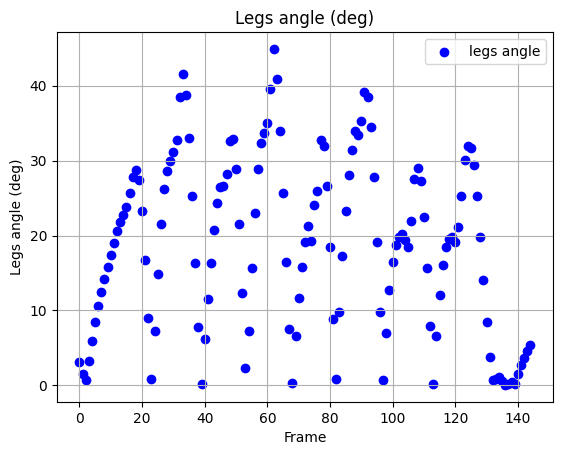

In [95]:
import matplotlib.pyplot as plt

frame_num = [i for i in range(len(lg))]

plt.scatter(frame_num, lg, color='blue', label='legs angle')

plt.title('Legs angle (deg)')
plt.legend()

plt.xlabel('Frame')
plt.ylabel('Legs angle (deg)')
plt.grid(True)
plt.show()

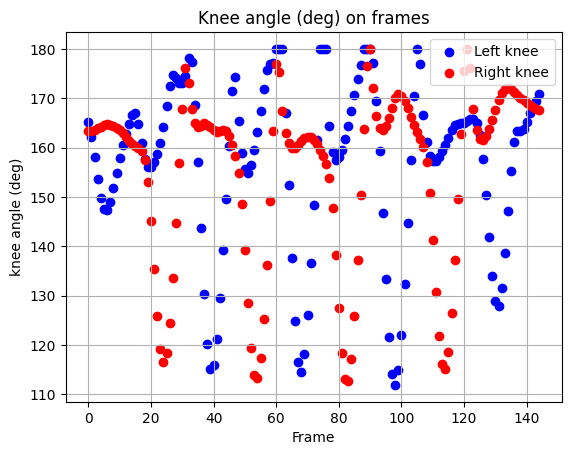

In [96]:
lk, rk = gpe.get_knees_angle()

frame_num = [i for i in range(len(lk))]

plt.scatter(frame_num, lk, color='blue', label='Left knee')
plt.scatter(frame_num, rk, color='red', label='Right knee')

plt.title('Knee angle (deg) on frames')
plt.legend()

plt.xlabel('Frame')
plt.ylabel('knee angle (deg)')
plt.grid(True)
plt.show()

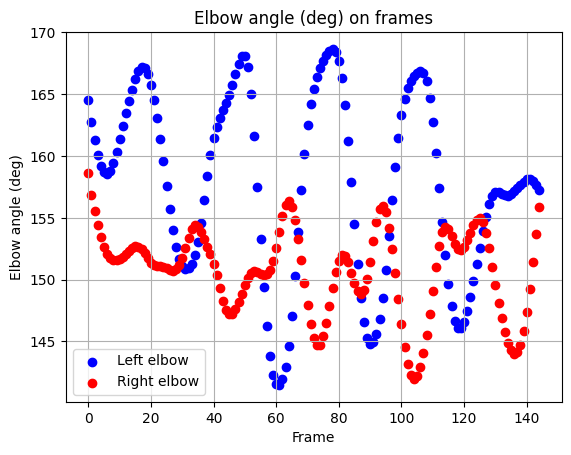

In [98]:
le, re = gpe.get_elbow_angle()

frame_num = [i for i in range(len(lk))]

plt.scatter(frame_num, le, color='blue', label='Left elbow')
plt.scatter(frame_num, re, color='red', label='Right elbow')

plt.title('Elbow angle (deg) on frames')
plt.legend()

plt.xlabel('Frame')
plt.ylabel('Elbow angle (deg)')
plt.grid(True)
plt.show()